# **Variational Autoencoders:**

################################################

Owner: Arnab Das

Dataset: mnist

##############################################

In [ ]:
# TensorFlow and tf.keras
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, Concatenate, concatenate, Softmax, ReLU, Reshape, UpSampling2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/LGM')

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()
train_images = train_images.reshape([-1, 28, 28, 1]).astype(np.float32) / 255

11493376/11490434 [==============================] - 0s 0us/step


### Custom layer:
> ####  The layer is to parameterize q(z|x) using P(epsilon), Mean & Variance and also for sampling the P(epsilon)

In [ ]:
class Parameterization(keras.layers.Layer):
    def __init__(self):
      super(Parameterization, self).__init__()

    def call(self, inputs, training = False):
      means, log_variances = tf.split(inputs, 2, axis=-1)
      variances = tf.math.exp(log_variances)
      if training:  
        samples = tf.random.normal(tf.shape(means)) * tf.math.sqrt(variances) + means   
      else:
        samples = tf.random.normal(tf.shape(means))
      return samples, tf.concat([means, variances], axis=-1)

### Model buildng:

> #### Generic model incorporating both part encode and decoder. Also it works in both mode training and drawing samples

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, hidden_size):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(128, (3, 3), activation='relu', padding='valid')
    self.mp1 = MaxPooling2D((2, 2), padding='valid')
    self.conv2 = Conv2D(128, (3, 3), activation='relu', padding='valid')
    self.mp2 = MaxPooling2D((2, 2), padding='same')
    self.conv3 = Conv2D(256, (3, 3), activation='relu', padding='valid')
    self.conv4 = Conv2D(256, (3, 3), activation='relu', padding='valid')
    self.flat = Flatten()
    self.fc_1 = Dense(256,  activation='relu')
    self.fc_2 = Dense(128, activation='relu' )
    self.coder = Dense(2*hidden_size)# Encoding
    self.pameterization = Parameterization()

    self.fc_3 = Dense(256, activation='relu')
    self.fc_4 = Dense(2304, activation='relu')
    self.reshape = Reshape((6,6, 64))
    self.upsample_1 = UpSampling2D((2, 2))
    self.deconv_1 = Conv2DTranspose(64, (3, 3), strides=(1, 1), activation='relu')
    self.upsample_2 = UpSampling2D((2, 2))
    self.deconv_2 = Conv2DTranspose(32, (3, 3), strides=(1, 1), activation='relu')
    self.conv5 = Conv2D(1, (3, 3), strides=(1, 1))


  def call(self, inputs, training= False):
    if training:
      x = self.conv1(inputs)
      x = self.mp1(x)
      x = self.conv2(x)
      x = self.mp2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.flat(x)
      x = self.fc_1(x)
      x = self.fc_2(x)
      x = self.coder(x)
      x, mu_var = self.pameterization(x, training)
    else:
      x, _ = self.pameterization(inputs, training)
    x = self.fc_3(x)
    x = self.fc_4(x)
    x = self.reshape(x)
    x = self.upsample_1(x) 
    x = self.deconv_1(x)
    x = self.upsample_2(x)
    x = self.deconv_2(x)
    x = self.conv5(x)

    if training:
      return [x, mu_var]
    else:
      return x

In [ ]:
def generation_loss_function(y_true, y_pred):
  generation_loss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred),
                                                 axis=[1,2,3]))
  return generation_loss

In [ ]:
def kl_loss(y_true, y_pred):
  mean_vec, sigma_vec = tf.split(y_pred, 2, axis=-1)
  kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mean_vec) + sigma_vec - tf.math.log(sigma_vec) - 1,1))
  return kl_loss

> #### I start the training with the loss weights [1, 0.3] corresponding to regeneration loss and KL loss.
I use a weight scheduler to increase the KL loss epoch over the epochs to reach 0.4. In order to put more importance on KL divergence loss as learning progresses to draw better samples. This is a tradeoff between good reconstructions and good samples.

Class for loss weight schedule callback is inspired by the blog
https://medium.com/dive-into-ml-ai/adaptive-weighing-of-loss-functions-for-multiple-output-keras-models-71a1b0aca66e


In [ ]:
class weightScheduler(tf.keras.callbacks.Callback):
  def __init__(self, loss_weights ):
    self.loss1_weight = loss_weights[0]
    self.loss2_weight = loss_weights[1]
  def on_epoch_end(self, epoch, logs={}):
      K.set_value(self.loss2_weight, self.loss2_weight+0.002)

In [ ]:
latent_size = 64
batch_size = 128
epoch_count = 50

loss1_weight = K.variable(1)
loss2_weight = K.variable(0.3)
loss_weights = [loss1_weight, loss2_weight]


weight_scheduler = weightScheduler(loss_weights)

loss = [generation_loss_function, kl_loss]
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta = 0.01, mode="min", restore_best_weights=True )
vae_model = MyModel(latent_size)
vae_model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3 ),
                     loss=loss, loss_weights=loss_weights,
                     metrics=[])
history = vae_model.fit(train_images, train_images,batch_size=batch_size, epochs=epoch_count, steps_per_epoch=None, callbacks=[weight_scheduler])

Epoch 1/50
469/469 [==============================] - 42s 20ms/step - loss: 163.1828 - output_1_loss: 156.3065 - output_2_loss: 22.9209
Epoch 2/50
469/469 [==============================] - 9s 19ms/step - loss: 105.8063 - output_1_loss: 93.3349 - output_2_loss: 41.2960
Epoch 3/50
469/469 [==============================] - 9s 20ms/step - loss: 93.8116 - output_1_loss: 81.9759 - output_2_loss: 38.9336
Epoch 4/50
469/469 [==============================] - 9s 20ms/step - loss: 88.1034 - output_1_loss: 76.7459 - output_2_loss: 37.1161
Epoch 5/50
469/469 [==============================] - 9s 20ms/step - loss: 85.0916 - output_1_loss: 73.9908 - output_2_loss: 36.0419
Epoch 6/50
469/469 [==============================] - 9s 20ms/step - loss: 83.2330 - output_1_loss: 72.2572 - output_2_loss: 35.4056
Epoch 7/50
469/469 [==============================] - 9s 20ms/step - loss: 81.8129 - output_1_loss: 70.9396 - output_2_loss: 34.8505
Epoch 8/50
469/469 [==============================] - 9s 20ms/ste

In [ ]:
vae_model.save_weights('/content/drive/MyDrive/Colab Notebooks/LGM/models/VAE/VAE_mnist.h5')

### Check for over-regularization:

> #### To ensure that the regularizer is not over regularizing, we print some of the reconstred image. As the assignment suggests a typical sign of “overregularization” is when all reconstructions look the same.

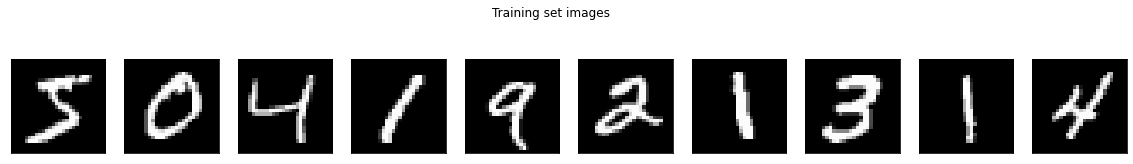

In [ ]:
reco, _ = vae_model(train_images[0:10], training = True)
fig = plt.figure(figsize=(20,7))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(train_images[i].squeeze(), cmap="gray")
  plt.xticks([])
  plt.yticks([])
plt.suptitle("Training set images", y= 0.7)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


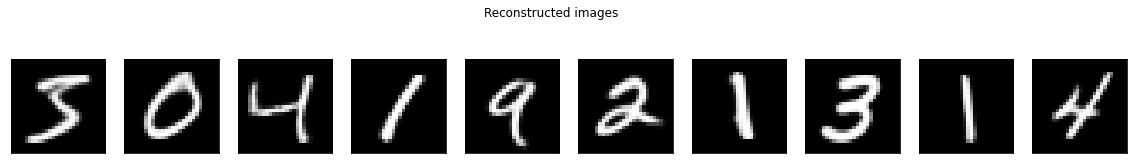

In [ ]:
fig = plt.figure(figsize=(20,7))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(1/(1+np.exp(-reco.numpy()[i].squeeze())), cmap="gray")
  plt.xticks([])
  plt.yticks([])
plt.suptitle("Reconstructed images", y= 0.7)
plt.show()

### Observation:
> in comparison to normal AE the reconstruction by the VAE is less blurry and sharp. This is happening because the normal AE maps the inputs to single vale in the latent space and this doesn't incorporate any effect of noise in generating the latent code. Where as the VAE maps each datapoint to a complete distribution for each latent space variable, putting high probability to values around the mean rather a single value. Hence the latest space is more tolerant of noise. 

### Drawing samples only using P(epsilon)

In [ ]:
dummyInput = np.zeros((10, 2*latent_size))
pred = vae_model.predict(dummyInput, False)

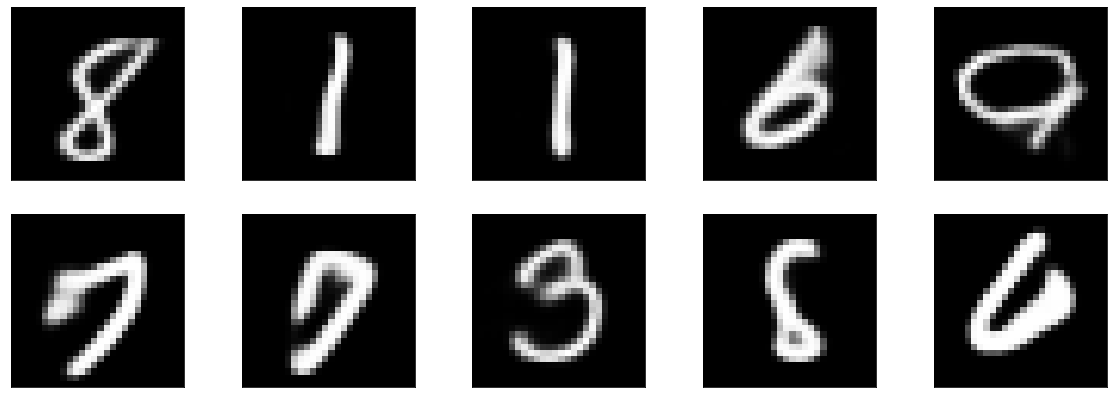

In [ ]:
import warnings
warnings.simplefilter('ignore')
fig = plt.figure(figsize=(20,7))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(1/(1+np.exp(-pred[i].squeeze())), cmap="gray")
  plt.xticks([])
  plt.yticks([])
plt.show()